<a href="https://colab.research.google.com/github/Arvind-55555/Measuring-CO-sequestration-of-a-tree/blob/main/Measuring_CO%E2%82%82_sequestration_of_a_tree_Model_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")

In [10]:
# 1. Simulate Data with More Realistic Characteristics
np.random.seed(42)
n_samples = 1000

# Species-specific growth and carbon storage parameters
species_params = {
    'Oak': {'growth_rate_mean': 0.03, 'growth_rate_std': 0.005,'base_carbon_seq': 0.18, 'optimal_temp': 18, 'optimal_rainfall': 100, 'optimal_soil_pH': 6.5, 'soil_coeff':0.2},
    'Pine': {'growth_rate_mean': 0.05, 'growth_rate_std': 0.008,'base_carbon_seq': 0.10, 'optimal_temp': 15, 'optimal_rainfall': 70, 'optimal_soil_pH': 5.5, 'soil_coeff':0.1},
    'Maple': {'growth_rate_mean': 0.04, 'growth_rate_std': 0.006,'base_carbon_seq': 0.15, 'optimal_temp': 20, 'optimal_rainfall': 90, 'optimal_soil_pH': 6.0, 'soil_coeff':0.15},
    'Birch': {'growth_rate_mean': 0.06, 'growth_rate_std': 0.009,'base_carbon_seq': 0.12, 'optimal_temp': 16, 'optimal_rainfall': 80, 'optimal_soil_pH': 5.0, 'soil_coeff':0.25}
}

# Simulate tree data
species = np.random.choice(list(species_params.keys()), size=n_samples)
age = np.random.randint(1, 30, size=n_samples)
location = np.random.choice(['Urban', 'Forest', 'Rural'], size=n_samples)
soil_type = np.random.choice(['Clay', 'Loam', 'Sand'], size=n_samples)
soil_nutrient = np.random.uniform(2, 8, size=n_samples) #randomized values for soil nutrients
soil_moisture = np.random.uniform(0.1, 0.7, size=n_samples)
soil_pH = np.random.uniform(4.5, 7.5, size=n_samples)

In [4]:
# Function to simulate weather data with some local correlation (Dummy API)
def get_weather_data(location, seed):
    np.random.seed(seed)
    if location == 'Urban':
        return np.random.normal(22, 5), np.random.normal(60, 20)
    elif location == 'Forest':
         return np.random.normal(18, 4), np.random.normal(90, 15)
    else: # Rural
         return np.random.normal(19, 3), np.random.normal(80, 10)

In [5]:
temperature = np.zeros(n_samples)
rainfall = np.zeros(n_samples)

for i in range(n_samples):
    temperature[i], rainfall[i] = get_weather_data(location[i],i)

In [6]:
#Function to calculate dimensions based on randomized growth rates
def calculate_dimensions(species, age):
    growth_rate = np.random.normal(species_params[species]['growth_rate_mean'], species_params[species]['growth_rate_std'])
    dbh = 5 * (1 + growth_rate * age) ** 0.5 #randomized growth rate
    height = 2 * (1 + growth_rate * age) ** 0.5 #randomized growth rate
    return dbh, height

In [7]:
dbh = np.zeros(n_samples)
height = np.zeros(n_samples)
for i in range(n_samples):
    dbh[i], height[i] = calculate_dimensions(species[i], age[i])

In [8]:
# Calculate CO2 sequestration with nuanced environmental impact and soil factors
annual_co2_seq = np.zeros(n_samples)

In [11]:
for i in range(n_samples):
    species_p = species_params[species[i]]

    base_carbon_seq = species_p['base_carbon_seq']
    # Modified environmental impact to reflect bell curve influence with +/- impact
    temp_effect = np.exp(-((temperature[i] - species_p['optimal_temp']) ** 2) / (2 * 5**2))
    rainfall_effect = np.exp(-((rainfall[i] - species_p['optimal_rainfall']) ** 2) / (2 * 30**2))
    soil_pH_effect = np.exp(-((soil_pH[i] - species_p['optimal_soil_pH']) ** 2) / (2 * 1**2))

    # Soil effect, based on nutrient and moisture
    soil_effect =  species_p['soil_coeff'] * soil_nutrient[i] * soil_moisture[i]


    annual_co2_seq[i] = base_carbon_seq * (dbh[i]*height[i] ) * temp_effect * rainfall_effect * soil_pH_effect * (1 + species_p['growth_rate_mean']) + soil_effect

In [12]:
df = pd.DataFrame({'species': species,
                   'age': age,
                   'location': location,
                   'temperature': temperature,
                   'rainfall': rainfall,
                   'soil_pH': np.random.uniform(4.5,7.5,size=n_samples),
                   'soil_nutrient': soil_nutrient,
                   'soil_moisture': soil_moisture,
                   'dbh': dbh,
                   'height': height,
                   'soil_type': soil_type,
                   'annual_co2_seq': annual_co2_seq})

In [13]:
df.head(10)

,species,age,location,temperature,rainfall,soil_pH,soil_nutrient,soil_moisture,dbh,height,soil_type,annual_co2_seq
0,Maple,22,Forest,25.056209,96.002358,4.777349,2.926758,0.595249,6.931009,2.772404,Loam,1.724121
1,Birch,17,Forest,24.497381,80.823654,5.873701,2.152687,0.606923,6.871421,2.748569,Loam,0.873217
2,Oak,9,Rural,17.749726,79.437332,5.683438,5.874934,0.249405,5.608083,2.243233,Sand,0.899687
3,Maple,1,Rural,24.365885,84.365099,7.101181,5.821414,0.446021,5.089466,2.035786,Loam,0.969330
4,Maple,21,Urban,22.252809,69.999027,5.231986,4.043625,0.140354,7.136788,2.854715,Clay,1.299191
5,Birch,20,Urban,24.206137,53.382597,7.400203,2.430271,0.156951,6.751950,2.700780,Sand,0.328461
6,Oak,13,Forest,16.752865,100.935059,7.374414,4.457773,0.699336,6.092334,2.436934,Sand,1.825560
7,Oak,28,Rural,24.071577,75.340626,5.242895,3.867305,0.295984,7.022003,2.808801,Clay,1.042042
8,Maple,16,Rural,19.273614,90.912827,5.544156,6.062724,0.548910,6.327679,2.531071,Sand,1.339810
9,Pine,29,Rural,19.003326,77.104559,7.186667,5.634675,0.583999,7.942186,3.176874,Sand,1.403047


In [14]:
# 2. Data Preprocessing
X = df.drop('annual_co2_seq', axis=1)
y = df['annual_co2_seq']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = ['age', 'temperature', 'rainfall', 'soil_pH','soil_nutrient', 'soil_moisture', 'dbh', 'height']
categorical_features = ['species', 'location','soil_type']

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [16]:
# 3. Model Training with Hyperparameter Tuning (Randomized Search)
def randomized_search(model, param_dist, X, y, cv=5, n_iter=10):
    random_search = RandomizedSearchCV(model, param_dist, n_iter=n_iter, cv=cv, scoring='neg_mean_squared_error', random_state=42)
    random_search.fit(X, y)
    best_model = random_search.best_estimator_
    best_score = np.sqrt(-random_search.best_score_)
    return best_model, best_score

In [18]:
import scipy.stats as st
# Define hyperparameter distributions to sample from
rf_params = {
    'n_estimators': st.randint(50, 200),
    'max_depth': [3, 5, 10, None],
    'min_samples_split': st.randint(2, 10),
    'min_samples_leaf': st.randint(1, 5)
}
gbr_params = {
    'n_estimators': st.randint(50, 200),
    'learning_rate': st.uniform(0.01, 0.2),
    'max_depth': [3, 5, 8],
    'min_samples_split': st.randint(2, 10),
    'min_samples_leaf': st.randint(1, 5)
}

In [19]:
#  Random search CV to find best models
print("Tuning Random Forest Model")
best_rf, best_rf_rmse = randomized_search(RandomForestRegressor(random_state=42), rf_params, X_train_processed, y_train)
print(f"Random Forest Tuned RMSE: {best_rf_rmse:.2f}")
print(f"Best Random Forest params: {best_rf}")

print("\nTuning Gradient Boosting Model")
best_gbr, best_gbr_rmse = randomized_search(GradientBoostingRegressor(random_state=42), gbr_params, X_train_processed, y_train)
print(f"Gradient Boosting Tuned RMSE: {best_gbr_rmse:.2f}")
print(f"Best Gradient Boosting params: {best_gbr}")

Tuning Random Forest Model
Random Forest Tuned RMSE: 0.53
Best Random Forest params: RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=6,
                      n_estimators=149, random_state=42)

Tuning Gradient Boosting Model
Gradient Boosting Tuned RMSE: 0.52
Best Gradient Boosting params: GradientBoostingRegressor(learning_rate=0.08649239825343255, min_samples_leaf=3,
                          min_samples_split=6, random_state=42)


In [20]:
# 4. Model Evaluation
def evaluate_model(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    print(f"Cross-validation RMSE scores: {rmse_scores}")
    print(f"Average RMSE: {rmse_scores.mean():.2f}")
    return rmse_scores

In [21]:
print("\nRandom Forest Performance After Tuning:")
rf_rmse_scores = evaluate_model(best_rf, X_train_processed, y_train)
best_rf.fit(X_train_processed, y_train)
rf_y_pred = best_rf.predict(X_test_processed)
rf_r2 = r2_score(y_test, rf_y_pred)
print(f"Random Forest Test R-squared: {rf_r2:.2f}")

print("\nGradient Boosting Performance After Tuning:")
gbr_rmse_scores = evaluate_model(best_gbr, X_train_processed, y_train)
best_gbr.fit(X_train_processed, y_train)
gbr_y_pred = best_gbr.predict(X_test_processed)
gbr_r2 = r2_score(y_test, gbr_y_pred)
print(f"Gradient Boosting Test R-squared: {gbr_r2:.2f}")


Random Forest Performance After Tuning:
Cross-validation RMSE scores: [0.51690987 0.50843632 0.53792466 0.48569957 0.59878639]
Average RMSE: 0.53
Random Forest Test R-squared: 0.54

Gradient Boosting Performance After Tuning:
Cross-validation RMSE scores: [0.51940862 0.5036814  0.52864381 0.46527511 0.5878218 ]
Average RMSE: 0.52
Gradient Boosting Test R-squared: 0.60


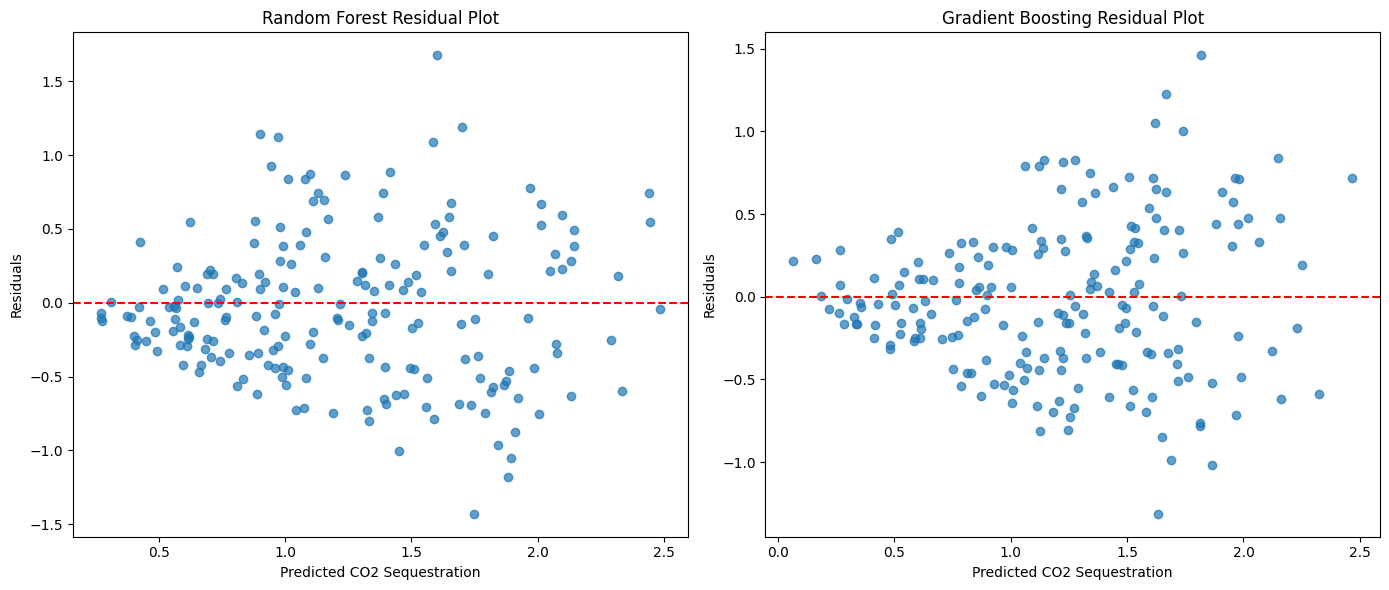

In [22]:
# 5. Analysis and Insights (Simplified)
# Compare residuals from both models
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

rf_residuals = y_test - rf_y_pred
gbr_residuals = y_test - gbr_y_pred

axs[0].scatter(rf_y_pred, rf_residuals, alpha=0.7)
axs[0].set_title('Random Forest Residual Plot')
axs[0].set_xlabel("Predicted CO2 Sequestration")
axs[0].set_ylabel("Residuals")
axs[0].axhline(0, color="red", linestyle="--")

axs[1].scatter(gbr_y_pred, gbr_residuals, alpha=0.7)
axs[1].set_title('Gradient Boosting Residual Plot')
axs[1].set_xlabel("Predicted CO2 Sequestration")
axs[1].set_ylabel("Residuals")
axs[1].axhline(0, color="red", linestyle="--")
plt.tight_layout()
plt.show()


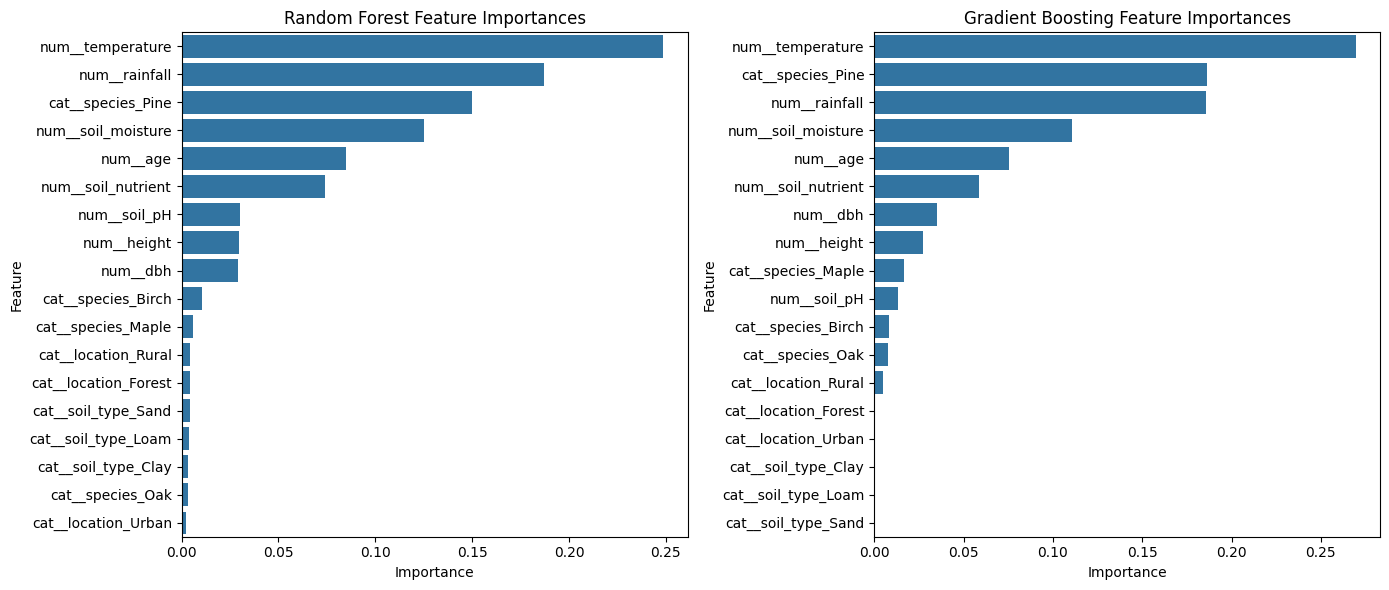

In [23]:
# Feature Importance
rf_feature_importance = pd.DataFrame({'Feature': preprocessor.get_feature_names_out(),
                                   'Importance': best_rf.feature_importances_})
rf_feature_importance = rf_feature_importance.reindex(rf_feature_importance.Importance.sort_values(ascending=False).index)

gbr_feature_importance = pd.DataFrame({'Feature': preprocessor.get_feature_names_out(),
                                   'Importance': best_gbr.feature_importances_})
gbr_feature_importance = gbr_feature_importance.reindex(gbr_feature_importance.Importance.sort_values(ascending=False).index)

fig, axs = plt.subplots(1, 2, figsize=(14,6))
sns.barplot(x="Importance", y="Feature", data=rf_feature_importance, ax=axs[0])
axs[0].set_title("Random Forest Feature Importances")
sns.barplot(x="Importance", y="Feature", data=gbr_feature_importance, ax=axs[1])
axs[1].set_title("Gradient Boosting Feature Importances")

plt.tight_layout()
plt.show()

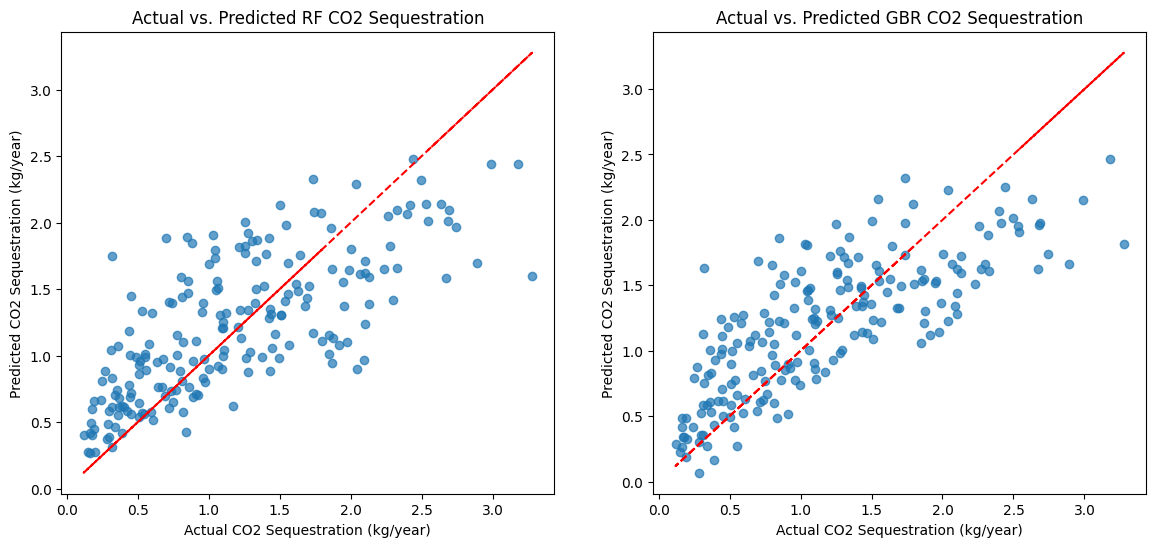

In [24]:
# Visualize prediction from both models
fig, axs = plt.subplots(1, 2, figsize=(14,6))

axs[0].scatter(y_test, rf_y_pred, alpha=0.7)
axs[0].set_xlabel("Actual CO2 Sequestration (kg/year)")
axs[0].set_ylabel("Predicted CO2 Sequestration (kg/year)")
axs[0].set_title("Actual vs. Predicted RF CO2 Sequestration")
axs[0].plot(y_test,y_test, color="red", linestyle="--")

axs[1].scatter(y_test, gbr_y_pred, alpha=0.7)
axs[1].set_xlabel("Actual CO2 Sequestration (kg/year)")
axs[1].set_ylabel("Predicted CO2 Sequestration (kg/year)")
axs[1].set_title("Actual vs. Predicted GBR CO2 Sequestration")
axs[1].plot(y_test,y_test, color="red", linestyle="--")

plt.show()